In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

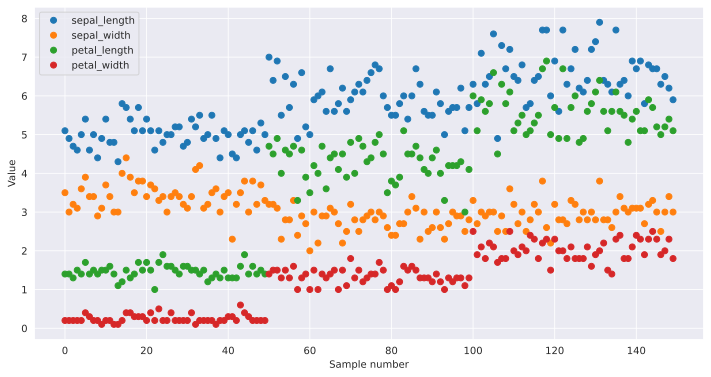

In [2]:
iris = sns.load_dataset("iris")

iris.plot(marker="o", linestyle="none", figsize=(12, 6))
plt.xlabel("Sample number")
plt.ylabel("Value")
plt.show()

In [3]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2, shuffle=True)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

In [5]:
class ModelIris(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(4, 64)
        self.hidden = nn.Linear(64, 64)
        self.output = nn.Linear(64, 3)

    def forward(self, x):
        x = f.relu(self.input(x))
        x = f.relu(self.hidden(x))
        x = self.output(x)

        return x

In [6]:
def create_dataloaders(batch_size):
    test_data_size = test_dataset.tensors[0].shape[0]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=test_data_size)

    return train_loader, test_loader

In [7]:
def create_model():
    model = ModelIris()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.001)

    return model, loss_func, optimizer

In [8]:
def train_model(batch_sizes, epochs):
    train_acc_results = np.zeros((epochs, len(batch_sizes)))
    test_acc_results = np.zeros((epochs, len(batch_sizes)))

    for i, batch_size in enumerate(batch_sizes):
        train_acc = []
        test_acc = []

        train_loader, test_loader = create_dataloaders(batch_size)
        model, loss_func, optimizer = create_model()

        for _ in range(epochs):
            model.train()

            batch_acc = []
            batch_loss = []

            for X, y in train_loader:
                preds = model(X)
                loss = loss_func(preds, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                argmax_bool = (torch.argmax(preds, dim=1) == y)
                argmax_float = argmax_bool.float()
                batch_acc.append(100 * torch.mean(argmax_float))
                batch_loss.append(loss.item())

            train_acc.append(np.mean(batch_acc))

            X, y = next(iter(test_loader))

            model.eval()
            with torch.no_grad():
                preds = model(X)

            argmax_bool = (torch.argmax(preds, dim=1) == y)
            argmax_float = argmax_bool.float()
            test_acc.append(100 * torch.mean(argmax_float))

        train_acc_results[:, i] = train_acc
        test_acc_results[:, i] = test_acc
    return train_acc_results, test_acc_results

In [9]:
batch_sizes = [2 ** i for i in range(1, 7)]
epochs = 500

train_acc, test_acc = train_model(batch_sizes, epochs)

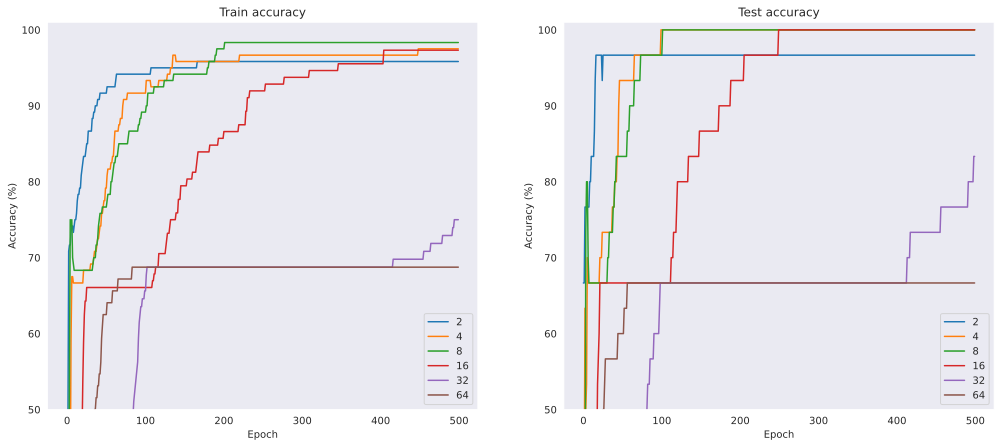

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(train_acc)
ax[0].set_title("Train accuracy")
ax[1].plot(test_acc)
ax[1].set_title("Test accuracy")

for i in range(2):
    ax[i].legend(batch_sizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.show()